In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

Завантаження та підготовка даних

In [ ]:
transform = transforms.ToTensor()

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)


In [ ]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(28*28, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 20)
        )

        self.decoder = nn.Sequential(
            nn.Linear(10, 64),
            nn.ReLU(),
            nn.Linear(64, 256),
            nn.ReLU(),
            nn.Linear(256, 28*28),
            nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def forward(self, x):
        x = x.view(-1, 28*28)
        h = self.encoder(x)
        mu, logvar = torch.chunk(h, 2, dim=1)
        z = self.reparameterize(mu, logvar)
        x_reconstructed = self.decoder(z)
        return x_reconstructed, mu, logvar

Функція втрат

In [ ]:
def loss_function(recon_x, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(recon_x, x.view(-1, 28*28), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

Ініціалізація моделі та оптимізатора

In [ ]:
model = VAE()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

Навчання

In [ ]:
num_epochs = 10
for epoch in range(num_epochs):
    for data in train_loader:
        img, _ = data
        recon_batch, mu, logvar = model(img)
        loss = loss_function(recon_batch, img, mu, logvar)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))


Epoch [1/10], Loss: 4574.5908
Epoch [2/10], Loss: 3818.4617
Epoch [3/10], Loss: 3880.4009
Epoch [4/10], Loss: 3707.3647
Epoch [5/10], Loss: 3534.8860
Epoch [6/10], Loss: 3643.2891
Epoch [7/10], Loss: 3515.7039
Epoch [8/10], Loss: 3665.7610
Epoch [9/10], Loss: 3282.0554
Epoch [10/10], Loss: 3801.2720


Візуалізація

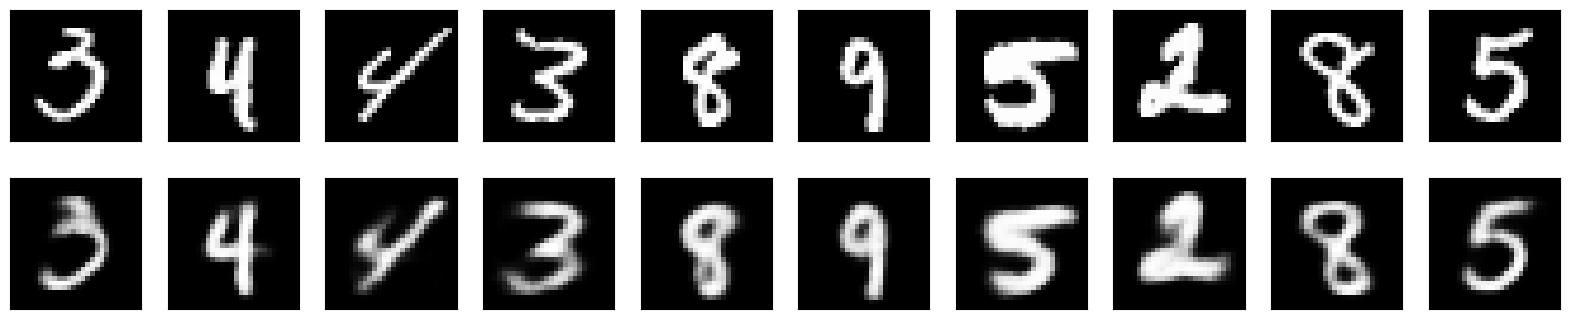

In [ ]:
with torch.no_grad():
    n_samples = 10
    sample_images, _ = next(iter(train_loader))
    recon_batch, _, _ = model(sample_images)
    sample_images = sample_images.numpy()
    recon_batch = recon_batch.view(-1, 1, 28, 28).numpy()

    plt.figure(figsize=(20, 4))
    for i in range(n_samples):
        # Оригінальне зображення
        ax = plt.subplot(2, n_samples, i + 1)
        plt.imshow(sample_images[i].squeeze(), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Реконструйоване зображення
        ax = plt.subplot(2, n_samples, i + 1 + n_samples)
        plt.imshow(recon_batch[i].squeeze(), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

У варіаційних автокодувальниках (VAE) відбувається генерація нових даних з деякого розподілу вхідних даних. Порівняно з звичайним автокодувальником, де зазвичай ми маємо закодований вектор фіксованої розмірності, у варіаційному автокодувальнику ми працюємо з розподілом, що дозволяє здійснювати більш гнучкий та плавний зсув в просторі.

У варіаційних автокодувальниках присутня компонента, яка відповідає за змінність (variability), яка дозволяє генерувати різні варіанти зображень з одного і того ж розподілу. Ця здатність до генерації нових зображень дозволяє зробити варіаційні автокодувальники корисними для завдань, таких як генерація нових зображень та аугментація даних.

У висновку можна зазначити, що варіаційні автокодувальники мають певні переваги порівняно зі звичайними автокодувальниками, зокрема здатність до генерації нових зображень та більш гнучкий зсув у просторі. Однак вони також можуть бути складнішими у навчанні та вимагати більшого обсягу даних для ефективного навчання.